In [19]:
using Pkg
using DotEnv
using Images


using FileIO, Images, MLDataUtils


include("src/test_name.jl")
using .Test_name
using Plots
using Flux
using MLUtils: shuffleobs, splitobs
using MLDataUtils

using Flux: DataLoader




┌ Warning: Replacing docs for `Main.Test_name.Download.Metadata.to_rcm_time :: Tuple{String}` in module `Main.Test_name.Download.Metadata`
└ @ Base.Docs docs/Docs.jl:243
┌ Warning: Replacing docs for `Main.Test_name.Download.Metadata.get_bbox :: Tuple{Any}` in module `Main.Test_name.Download.Metadata`
└ @ Base.Docs docs/Docs.jl:243
┌ Warning: Replacing docs for `Main.Test_name.Download.Metadata.bounding_box_to_geojson :: Tuple{}` in module `Main.Test_name.Download.Metadata`
└ @ Base.Docs docs/Docs.jl:243
┌ Warning: Replacing docs for `Main.Test_name.Download.Metadata.coordinate_to_geojson :: Union{Tuple{T}, Tuple{T, T}} where T<:Real` in module `Main.Test_name.Download.Metadata`
└ @ Base.Docs docs/Docs.jl:243
┌ Warning: Replacing docs for `Main.Test_name.Download.Metadata.wkt_to_tuples :: Tuple{Any}` in module `Main.Test_name.Download.Metadata`
└ @ Base.Docs docs/Docs.jl:243


In [5]:
using Flux
test_model = Chain(Dense(10, 5), Dense(5, 2))
Flux.params(test_model)  # This should work without error


Params([Float32[0.14621218 -0.41465333 … -0.57383245 -0.29943618; 0.032401044 0.6317958 … 0.13057013 -0.45457432; … ; -0.54754645 -0.56950116 … -0.6053931 -0.082647234; -0.6018515 0.10561996 … -0.58728564 -0.21372673], Float32[0.0, 0.0, 0.0, 0.0, 0.0], Float32[-0.46775183 0.03428332 … -0.4449605 0.80544496; -0.03219111 0.18027616 … 0.5594763 0.6337556], Float32[0.0, 0.0]])

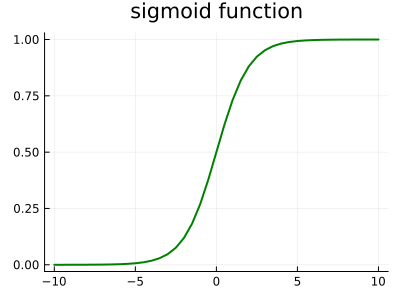

In [2]:
begin
    gr()
    plot(-10:0.5:10, sigmoid.(-10:0.5:10), label=false, title="sigmoid function", lw=2, size=(400, 300), color="Green")
end

In [32]:
function load_and_split_datasets(path_ships, path_icebergs)
    function load_images(folder_path, label)
        image_files = readdir(folder_path)
        images = [convert(Matrix{Float64}, Gray.(load(joinpath(folder_path, file)))) for file in image_files]
        labels = fill(label, length(images))
        return images, labels
    end

    function extract_data(data)
        images = [item[1] for item in data]
        labels = [item[2] for item in data]
        return images, labels
    end

    # Load images from folders
    ship_images, ship_labels = load_images(path_ships, 1)
    iceberg_images, iceberg_labels = load_images(path_icebergs, 0)

    # Combine and shuffle
    X = vcat(ship_images, iceberg_images)
    Y = vcat(ship_labels, iceberg_labels)
    data = shuffleobs(collect(zip(X, Y)))

    # Split the data
    (train_val, test) = splitobs(data, at=0.8)   # 80% for training+validation, 20% for test
    (train, val) = splitobs(train_val, at=0.75)  # 75% of 80% for training, 25% of 80% for validation

    # Extract images and labels
    train_X, train_Y = extract_data(train)
    val_X, val_Y = extract_data(val)
    test_X, test_Y = extract_data(test)

    return train_X, train_Y, val_X, val_Y, test_X, test_Y
end



function create_model(; img_size=(75, 75), filter_size=3, num_filters=16, dense_units=128)
    # Calculate the size after first Conv and MaxPool
    conv1_size = div.(img_size .- (filter_size - 1), 2)
    
    # Calculate the size after second Conv and MaxPool
    conv2_size = div.(conv1_size .- (filter_size - 1), 2)

    # Number of features after flattening
    flattened_size = prod(conv2_size) * 2 * num_filters  # 2 * num_filters is the number of output channels

    return Chain(
        Conv((filter_size, filter_size), 1 => num_filters, relu),
        MaxPool((2,2)),
        Conv((filter_size, filter_size), num_filters => 2 * num_filters, relu),
        MaxPool((2,2)),
        Flux.flatten,
        Dense(flattened_size, dense_units, relu),
        Dense(dense_units, 1),
        sigmoid
    )
end



function prepare_images(images::Vector{Matrix{Float64}})
    # Convert to Float32 and add a singleton dimension for the channel and batch
    reshaped_images = [reshape(Float32.(image), size(image, 1), size(image, 2), 1, 1) for image in images]
    # Concatenate all images along the 4th dimension
    return cat(reshaped_images..., dims=4)
end




prepare_images (generic function with 1 method)

In [33]:
train_X, train_Y, val_X, val_Y, test_X, test_Y = load_and_split_datasets("/Users/kaaso/Documents/coding/JuliaEO2024/data/ship no ship dataset/ship/png", "/Users/kaaso/Documents/coding/JuliaEO2024/data/ship no ship dataset/iceberg/png")

([[0.5245593957427329 0.5689784084840162 … 0.4910963607232776 0.48587777523460746; 0.5586480506599527 0.5397878995956359 … 0.4951247425040055 0.5001297016861219; … ; 0.5508354314488442 0.5538109407187 … 0.543297474631876 0.5737239642938887; 0.5477531090257115 0.536614023041123 … 0.556923781185626 0.5813839932860304], [0.44232852674143586 0.424780651560235 … 0.4654001678492409 0.4330052643625544; 0.4566262302586404 0.43894102388036926 … 0.45233844510566873 0.46123445487144277; … ; 0.47385366598001066 0.5229571984435798 … 0.49445334554055087 0.48003356984817275; 0.4643625543602655 0.5014419775692378 … 0.4769359884031434 0.4494850080109865], [0.5746395056076905 0.6196231021591516 … 0.507011520561532 0.516563668268864; 0.5776607919432364 0.5425345235370412 … 0.5144274052033264 0.5201953154802778; … ; 0.5378957808804455 0.5477683680476082 … 0.48087281605249105 0.49620813305867095; 0.5272297245746548 0.5641718165865568 … 0.5064164187075608 0.5172045471885253], [0.5033646143282215 0.522987716

In [34]:
model = create_model()

Chain(
  Conv((3, 3), 1 => 16, relu),          # 160 parameters
  MaxPool((2, 2)),
  Conv((3, 3), 16 => 32, relu),         # 4_640 parameters
  MaxPool((2, 2)),
  Flux.flatten,
  Dense(9248 => 128, relu),             # 1_183_872 parameters
  Dense(128 => 1),                      # 129 parameters
  NNlib.σ,
)                   # Total: 8 arrays, 1_188_801 parameters, 4.536 MiB.

((shape of width of the filter * shape of height of the filter * number of filters in the previous layer+1)*number of filters). Where the term “filter” refer to the number of filters in the current layer.

((m * n * d)+1)* k)

In [9]:
function loss_fn(predictions, targets)
    # Ensure that predictions are clipped to avoid log(0)
    eps = 1e-7
    predictions = clamp.(predictions, eps, 1 - eps)
    return -mean(targets .* log.(predictions) + (1 .- targets) .* log.(1 .- predictions))
end


loss_fn (generic function with 1 method)

In [24]:
using Statistics

In [25]:
function train_model(model, train_X, train_Y, val_X, val_Y, epochs, learning_rate, batch_size)
    train_X_prepared = prepare_images(train_X)
    val_X_prepared = prepare_images(val_X)
    train_Y = reshape(Float32.(train_Y), 1, :)
    val_Y = reshape(Float32.(val_Y), 1, :)

    opt = ADAM(learning_rate)
    loss(x, y) = loss_fn(model(x), y)
    accuracy(x, y) = mean((model(x) .> 0.5) .== y)

    # Metrics storage
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in 1:epochs
        # Training
        train_loss = 0
        train_acc = 0
        count = 0
        for (x, y) in DataLoader((train_X_prepared, train_Y), batchsize=batch_size, shuffle=true)
            grads = gradient(Flux.params(model)) do
                l = loss(x, y)
                return l
            end
            update!(opt, Flux.params(model), grads)

            train_loss += loss(x, y)
            train_acc += accuracy(x, y)
            count += 1
        end
        push!(train_losses, train_loss / count)
        push!(train_accuracies, train_acc / count)

        # Validation
        val_loss = loss(val_X_prepared, val_Y)
        val_acc = accuracy(val_X_prepared, val_Y)
        push!(val_losses, val_loss)
        push!(val_accuracies, val_acc)

        @info "Epoch $epoch: Train Loss = $(train_losses[end]), Train Accuracy = $(train_accuracies[end]), Validation Loss = $(val_losses[end]), Validation Accuracy = $(val_accuracies[end])"
    end

    return train_losses, train_accuracies, val_losses, val_accuracies
end


train_model (generic function with 1 method)

In [30]:
Pkg.status("Flux")

Status `~/Documents/coding/JuliaEO2024/Project.toml`
  [587475ba] Flux v0.14.7


In [ ]:


# Create the model
model = create_model()



# Train the model



In [13]:
using Flux

# ResNet Block
function ResBlock(channels)
    skip_connection = Chain(
        Conv((3, 3), channels => channels, pad = (1, 1), stride = (1, 1)),
        BatchNorm(channels, relu),
        Conv((3, 3), channels => channels, pad = (1, 1), stride = (1, 1)),
        BatchNorm(channels)
    )
    return Chain(
        skip_connection,
        (x -> relu.(x + skip_connection(x)))
    )
end

# Convolutional Block
function ConvBlock(channels_in, channels_out; kernel_size=(3, 3), stride=(1, 1), pad=(1, 1))
    Chain(
        Conv(kernel_size, channels_in => channels_out, stride = stride, pad = pad),
        BatchNorm(channels_out, relu)
    )
end

# Upsample Block for FPN
function UpsampleBlock(channels_in, channels_out)
    Chain(
        ConvTranspose((2, 2), channels_in => channels_out, stride = (2, 2)),
        BatchNorm(channels_out, relu)
    )
end


UpsampleBlock (generic function with 1 method)

In [27]:
function create_advanced_model()
    # Initial Convolutional Layer
    initial_conv = ConvBlock(1, 16, kernel_size=(7, 7), stride=(2, 2), pad=(3, 3))

    # ResNet Blocks
    res_blocks = Chain(
        ResBlock(16),
        MaxPool((2,2)),
        ResBlock(16),
        Dropout(0.5)
    )

    # Feature Pyramid Network Components
    lateral_1 = ConvBlock(16, 64, kernel_size=(1, 1))
    lateral_2 = ConvBlock(16, 64, kernel_size=(1, 1))
    upsample = UpsampleBlock(64, 64)

    # Final Layers
    final_layers = Chain(
        GlobalMeanPool(),
        Flux.flatten,
        Dense(64, 1),
        sigmoid
    )

    # Complete Model
    Chain(
        initial_conv,
        res_blocks,
        x -> begin
            l1 = lateral_1(x)
            l2 = lateral_2(x)
            upsampled = upsample(l1 .+ l2)
            final_layers(upsampled)
        end
    )
end

model = create_advanced_model();


In [41]:
using Flux

function ResNetBlock(channels)
    inner_layers = Chain(
        Conv((3, 3), channels => channels, stride = 1, pad = 1),
        BatchNorm(channels, relu),
        Conv((3, 3), channels => channels, stride = 1, pad = 1),
        BatchNorm(channels)
    )
    
    # SkipConnection takes inner_layers and a function to combine input and output
    SkipConnection(inner_layers, (x, y) -> relu.(x .+ y))
end


# Define the full model
function create_model()
    Chain(
        # Initial convolutional layer
        Conv((7, 7), 1 => 16, stride = 2, pad = 3),
        BatchNorm(16, relu),
        MaxPool((3, 3), stride = 2, pad = 1),

        # ResNet blocks
        ResNetBlock(16),
        ResNetBlock(16),
        Dropout(0.5),  # Dropout layer for regularization

        # Classification layers
        GlobalMeanPool(),
        flatten,
        Dense(16, 1),  # Adjust the output size based on your requirements
        sigmoid  # Sigmoid activation for binary classification
    )
end

model = create_model()


Chain(
  Conv((7, 7), 1 => 16, pad=3, stride=2),  # 800 parameters
  BatchNorm(16, relu),                  # 32 parameters, plus 32
  MaxPool((3, 3), pad=1, stride=2),
  SkipConnection(
    Chain(
      Conv((3, 3), 16 => 16, pad=1),    # 2_320 parameters
      BatchNorm(16, relu),              # 32 parameters, plus 32
      Conv((3, 3), 16 => 16, pad=1),    # 2_320 parameters
      BatchNorm(16),                    # 32 parameters, plus 32
    ),
    var"#72#73"(),
  ),
  SkipConnection(
    Chain(
      Conv((3, 3), 16 => 16, pad=1),    # 2_320 parameters
      BatchNorm(16, relu),              # 32 parameters, plus 32
      Conv((3, 3), 16 => 16, pad=1),    # 2_320 parameters
      BatchNorm(16),                    # 32 parameters, plus 32
    ),
    var"#72#73"(),
  ),
  Dropout(0.5),
  GlobalMeanPool(),
  MLUtils.flatten,
  Dense(16 => 1),                       # 17 parameters
  NNlib.σ,
)         # Total: 22 trainable arrays, 10_257 parameters,
          # plus 10 non-trainable, 

In [15]:
# Hyperparameters
epochs = 10
learning_rate = 0.0001
batch_size = 32

32

In [35]:
using Plots

# Train the model and get the metrics
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_X, train_Y, val_X, val_Y, epochs, learning_rate, batch_size)


┌ Error: Hint-handler #41 for MethodError in ImageCore caused an error
└ @ Base.Experimental experimental.jl:321


MethodError: MethodError: no method matching (::ChainRulesCore.ProjectTo{Float64, NamedTuple{(), Tuple{}}})(::Matrix{Float64})

Closest candidates are:
  (::ChainRulesCore.ProjectTo{T})(!Matched::Integer) where T<:AbstractFloat
   @ ChainRulesCore ~/.julia/packages/ChainRulesCore/zoCjl/src/projection.jl:172
  (::ChainRulesCore.ProjectTo)(!Matched::ChainRulesCore.Thunk)
   @ ChainRulesCore ~/.julia/packages/ChainRulesCore/zoCjl/src/projection.jl:124
  (::ChainRulesCore.ProjectTo)(!Matched::ChainRulesCore.InplaceableThunk)
   @ ChainRulesCore ~/.julia/packages/ChainRulesCore/zoCjl/src/projection.jl:125
  ...


In [ ]:

# Plotting Loss
plot(1:epochs, train_losses, label="Train Loss", title="Training and Validation Loss", xlabel="Epoch", ylabel="Loss", legend=:topright)
plot!(1:epochs, val_losses, label="Validation Loss")

# Plotting Accuracy
plot(1:epochs, train_accuracies, label="Train Accuracy", title="Training and Validation Accuracy", xlabel="Epoch", ylabel="Accuracy", legend=:bottomright)
plot!(1:epochs, val_accuracies, label="Validation Accuracy")





# test

In [ ]:
# Binary classification metrics
function calculate_accuracy(predictions, labels)
    thresholded_predictions = predictions .> 0.5
    return mean(thresholded_predictions .== labels)
end

function calculate_precision(predictions, labels)
    thresholded_predictions = predictions .> 0.5
    true_positives = sum((thresholded_predictions .== 1) .& (labels .== 1))
    predicted_positives = sum(thresholded_predictions)
    return predicted_positives == 0 ? 0 : true_positives / predicted_positives
end

function calculate_metric_at_threshold(predictions, labels, threshold, metric_function)
    thresholded_predictions = predictions .> threshold
    return metric_function(thresholded_predictions, labels)
end

function precision(thresholded_predictions, labels)
    true_positives = sum((thresholded_predictions .== 1) .& (labels .== 1))
    predicted_positives = sum(thresholded_predictions)
    return predicted_positives == 0 ? 0 : true_positives / predicted_positives
end

function recall(thresholded_predictions, labels)
    true_positives = sum((thresholded_predictions .== 1) .& (labels .== 1))
    actual_positives = sum(labels)
    return actual_positives == 0 ? 0 : true_positives / actual_positives
end

function f1_score(thresholded_predictions, labels)
    prec = precision(thresholded_predictions, labels)
    rec = recall(thresholded_predictions, labels)
    return prec + rec == 0 ? 0 : 2 * (prec * rec) / (prec + rec)
end




In [ ]:
thresholds = 0.0:0.01:1.0
precision_values = [calculate_metric_at_threshold(test_predictions, test_Y, t, precision) for t in thresholds]
recall_values = [calculate_metric_at_threshold(test_predictions, test_Y, t, recall) for t in thresholds]
f1_values = [calculate_metric_at_threshold(test_predictions, test_Y, t, f1_score) for t in thresholds]


In [ ]:
using Plots

# Precision vs Threshold
plot(thresholds, precision_values, title="Precision vs Threshold", xlabel="Threshold", ylabel="Precision", legend=false)


In [ ]:
# Recall vs Threshold
plot(thresholds, recall_values, title="Recall vs Threshold", xlabel="Threshold", ylabel="Recall", legend=false)


In [ ]:


# F1 Score vs Threshold
plot(thresholds, f1_values, title="F1 Score vs Threshold", xlabel="Threshold", ylabel="F1 Score", legend=false)


In [ ]:
test_X_prepared = prepare_images(test_X) # Use the same prepare_images function
test_Y = reshape(Float32.(test_Y), 1, :) # Reshape labels

test_predictions = model(test_X_prepared)


In [ ]:
test_accuracy = calculate_accuracy(test_predictions, test_Y)
test_precision = calculate_precision(test_predictions, test_Y)
test_recall = calculate_recall(test_predictions, test_Y)
test_f1_score = calculate_f1_score(test_predictions, test_Y)
test_loss = calculate_loss(test_predictions, test_Y)

println("Test Accuracy: $test_accuracy")
println("Test Precision: $test_precision")
println("Test Recall: $test_recall")
println("Test F1 Score: $test_f1_score")
println("Test Loss: $test_loss")


# Plot

In [ ]:
function precision(predictions, labels)
    true_positives = sum(predictions .& labels)
    total_predicted_positives = sum(predictions)
    return total_predicted_positives == 0 ? 0 : true_positives / total_predicted_positives
end

function recall(predictions, labels)
    true_positives = sum(predictions .& labels)
    total_actual_positives = sum(labels)
    return total_actual_positives == 0 ? 0 : true_positives / total_actual_positives
end

function f1_score(predictions, labels)
    prec = precision(predictions, labels)
    rec = recall(predictions, labels)
    return prec + rec == 0 ? 0 : 2 * prec * rec / (prec + rec)
end

function accuracy(predictions, labels)
    return mean(predictions .== labels)
end

function calculate_metrics(predictions, labels, threshold, metric_function)
    thresholded_predictions = predictions .> threshold
    return metric_function(thresholded_predictions, labels)
end


In [ ]:
function compute_class_metrics(predictions, labels, class_label, thresholds, metric_function)
    return [calculate_metrics(predictions, labels .== class_label, t, metric_function) for t in thresholds]
end

# Example thresholds
thresholds = 0.0:0.01:1.0

# Assuming test_predictions is a vector of model outputs and test_Y are the true labels
# Replace these with your actual test data
ships_precision = compute_class_metrics(test_predictions, test_Y, 1, thresholds, precision)
ships_recall = compute_class_metrics(test_predictions, test_Y, 1, thresholds, recall)
ships_f1= compute_class_metrics(test_predictions, test_Y, 0, thresholds, f1_score)
ships_accuracy = compute_class_metrics(test_predictions, test_Y, 0, thresholds, accuracy)
# ... similarly for F1 score and accuracy

icebergs_precision = compute_class_metrics(test_predictions, test_Y, 0, thresholds, precision)
icebergs_recall = compute_class_metrics(test_predictions, test_Y, 0, thresholds, recall)
icebergs_f1= compute_class_metrics(test_predictions, test_Y, 0, thresholds, f1_score)
icebergs_accuracy = compute_class_metrics(test_predictions, test_Y, 0, thresholds, accuracy)
# ... similarly for F1 score and accuracy


In [ ]:
function compute_metrics(predictions, labels, threshold, metric_fn)
    thresholded_predictions = predictions .> threshold
    return metric_fn(thresholded_predictions, labels)
end

precision(predictions, labels) = sum(predictions .& labels) / max(1, sum(predictions))
recall(predictions, labels) = sum(predictions .& labels) / max(1, sum(labels))
f1_score(predictions, labels) = let p = precision(predictions, labels); r = recall(predictions, labels); 2 * p * r / max(1, p + r) end
accuracy(predictions, labels) = mean(predictions .== labels)


In [ ]:
thresholds = 0:0.01:1
metrics = Dict()

for class_label in [0, 1]
    class_metrics = Dict()
    for metric_fn in [precision, recall, f1_score, accuracy]
        class_metrics[metric_fn] = [compute_metrics(test_predictions, test_Y .== class_label, t, metric_fn) for t in thresholds]
    end
    metrics[class_label] = class_metrics
end


In [ ]:
using Plots

for (metric_name, metric_fn) in [("Precision", precision), ("Recall", recall), ("F1 Score", f1_score), ("Accuracy", accuracy)]
    p = plot(title = "$metric_name vs Threshold", xlabel = "Threshold", ylabel = metric_name)
    plot!(p, thresholds, metrics[1][metric_fn], label = "Ships $metric_name")
    plot!(p, thresholds, metrics[0][metric_fn], label = "Icebergs $metric_name")
    display(p)
end


In [ ]:
using Plots

# Precision Plot
plot(thresholds, ships_precision, label="Ships Precision")
plot!(thresholds, icebergs_precision, label="Icebergs Precision", title="Precision vs Threshold", xlabel="Threshold", ylabel="Precision")


# ... similar plots for F1 score and accuracy


In [ ]:

# Recall Plot
plot(thresholds, ships_recall, label="Ships Recall")
plot!(thresholds, icebergs_recall, label="Icebergs Recall", title="Recall vs Threshold", xlabel="Threshold", ylabel="Recall")

In [ ]:

# Recall Plot
plot(thresholds, ships_accuracy, label="Ships Recall")


aa